In [1]:
# Import necessary libraries
import os
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import genpareto
import matplotlib.pyplot as plt
import seaborn as sns

# set working directory
os.chdir('/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/Data')

In [2]:
# Load the data
gdf = gpd.read_file('flowlines_with_pop_density.geojson')

# Check for missing values
print(gdf.isnull().sum())

# Replace NaN values with 'No Spill'
gdf['root_cause'] = gdf['root_cause'].fillna('No Spill')

operator_number                0
flowline_id                    0
location_id                    0
status                         0
location_type                  0
fluid                          0
material                       0
diameter_in                    0
length_ft                      0
max_operating_pressure         0
shape_length                   0
line_age_yr                    0
root_cause                274652
risk                           0
index                          0
average_pop_density           72
geometry                       0
dtype: int64


In [3]:
gdf = gdf.dropna(subset=['average_pop_density'])

# Check for missing values
print(gdf.isnull().sum())

operator_number           0
flowline_id               0
location_id               0
status                    0
location_type             0
fluid                     0
material                  0
diameter_in               0
length_ft                 0
max_operating_pressure    0
shape_length              0
line_age_yr               0
root_cause                0
risk                      0
index                     0
average_pop_density       0
geometry                  0
dtype: int64


In [4]:
import geopandas as gpd
from shapely.geometry import Point

# Create a function to fill missing values based on proximity
def fill_missing_pop_density(gdf, value_col='average_pop_density', geometry_col='geometry'):
    # Separate rows with and without missing values
    missing_values = gdf[gdf[value_col].isna()]
    non_missing_values = gdf[~gdf[value_col].isna()]
    
    # For each geometry with a missing value, find the nearest neighbors
    filled_values = []
    for missing_geom in missing_values[geometry_col]:
        # Calculate distances to all other geometries
        non_missing_values['distance'] = non_missing_values[geometry_col].distance(missing_geom)
        # Get the closest geometry or use an average of the closest few
        nearest = non_missing_values.nsmallest(1, 'distance')
        filled_value = nearest[value_col].mean()  # Use the mean of nearest values
        filled_values.append(filled_value)
    
    # Assign the filled values back to the original DataFrame
    gdf.loc[gdf[value_col].isna(), value_col] = filled_values
    return gdf

# Example usage
gdf = fill_missing_pop_density(gdf, value_col='average_pop_density', geometry_col='geometry')

In [5]:
# Check for missing values
print(gdf.isnull().sum())

operator_number           0
flowline_id               0
location_id               0
status                    0
location_type             0
fluid                     0
material                  0
diameter_in               0
length_ft                 0
max_operating_pressure    0
shape_length              0
line_age_yr               0
root_cause                0
risk                      0
index                     0
average_pop_density       0
geometry                  0
dtype: int64


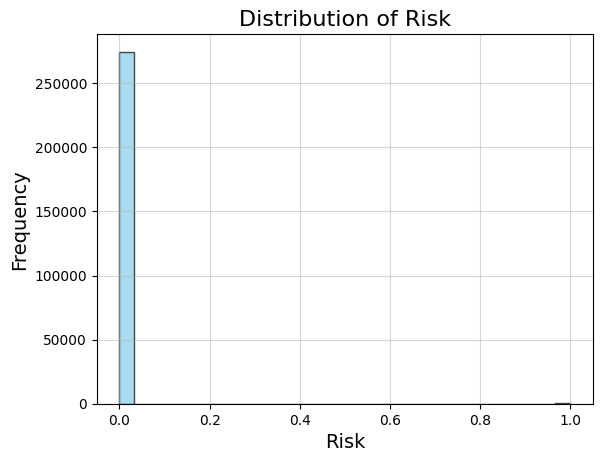

In [6]:
# Plot the distribution of the 'risk' column
plt.hist(gdf['risk'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    
# Add titles and labels
plt.title('Distribution of Risk', fontsize=16)
plt.xlabel('Risk', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, alpha=0.5)
    
# Show the plot
plt.show()

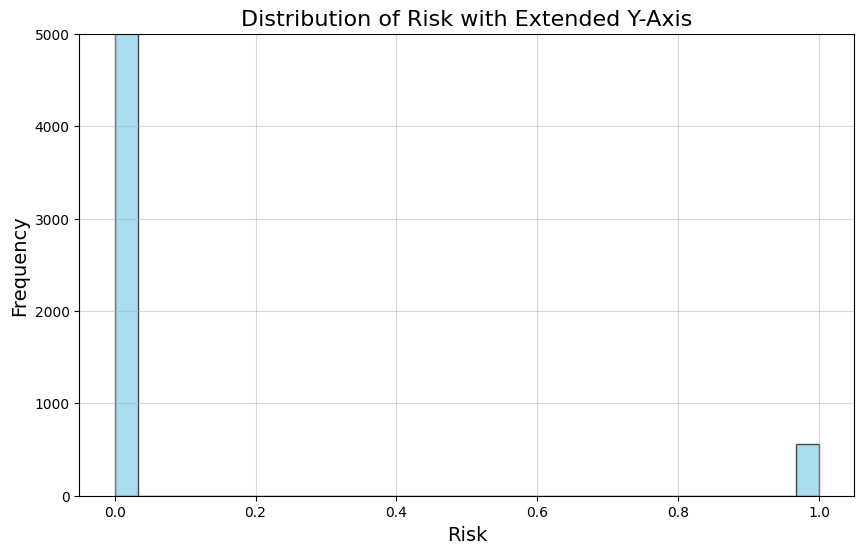

In [7]:
# Adjusting the y-axis to zoom in
plt.figure(figsize=(10, 6))

# Histogram of 'risk'
plt.hist(gdf['risk'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)

# Add titles and labels
plt.title('Distribution of Risk with Extended Y-Axis', fontsize=16)
plt.xlabel('Risk', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.ylim(0, 5000)  # Adjust the y-axis to highlight risk = 1
plt.grid(True, alpha=0.5)

# Show the plot
plt.show()

In [8]:
# Count the frequency of each unique value in the 'risk' column
if 'risk' in gdf.columns:
    risk_counts = gdf['risk'].value_counts()

    # Display the counts
    print("Counts of unique risk values:")
    print(risk_counts)
else:
    print("The 'risk' column is not found in the dataset.")

Counts of unique risk values:
risk
0    274580
1       562
Name: count, dtype: int64


In [9]:
print(gdf.columns)

Index(['operator_number', 'flowline_id', 'location_id', 'status',
       'location_type', 'fluid', 'material', 'diameter_in', 'length_ft',
       'max_operating_pressure', 'shape_length', 'line_age_yr', 'root_cause',
       'risk', 'index', 'average_pop_density', 'geometry'],
      dtype='object')


In [10]:
gdf = gdf.drop(columns=['index'])

In [11]:
# List of categorical variables
categorical_vars = ['status', 'location_type', 'fluid', 'material', 'root_cause', 'operator_number', 'flowline_id', 'location_id']
# List of numerical variables
numerical_vars = ['diameter_in', 'length_ft', 'max_operating_pressure',
                  'shape_length', 'line_age_yr']

# Perform one-hot encoding
gdf_encoded = pd.get_dummies(gdf, columns=categorical_vars, drop_first=True)

# Keep geometry for later use
gdf_geometry = gdf[['geometry']]

# Exclude geometry from the features
gdf_encoded = gdf_encoded.drop('geometry', axis=1)

# Define the feature matrix X and target vector y
X = gdf_encoded.drop('risk', axis=1)
y = gdf_encoded['risk']

# Standardize numerical features
scaler = StandardScaler()
X[numerical_vars] = scaler.fit_transform(X[numerical_vars])

# Similarity Matrix

In [12]:
# Subset of instances where risk = 1
X_risk1 = X[y == 1]

# Compute cosine similarity between all instances and risk = 1 instances
similarity_matrix = cosine_similarity(X, X_risk1)

# Average similarity scores for each instance
avg_similarity = similarity_matrix.mean(axis=1)

# Convert to a DataFrame
risk_scores = pd.DataFrame({
    'avg_similarity': avg_similarity
}, index=X.index)

In [13]:
# Normalize the risk scores
min_score = risk_scores['avg_similarity'].min()
max_score = risk_scores['avg_similarity'].max()

risk_scores['risk_probability'] = (
    risk_scores['avg_similarity'] - min_score
) / (max_score - min_score)

# Assign a risk probability of 1 to all risk = 1 instances
risk_scores.loc[y == 1, 'risk_probability'] = 1.0

In [14]:
#  gdf_result is the GeoDataFrame with risk probabilities
gdf_result = gdf.join(risk_scores['risk_probability'])

# Save the updated file
gdf_result.to_file('w_pop_sim_result.geojson',driver='GeoJSON') 

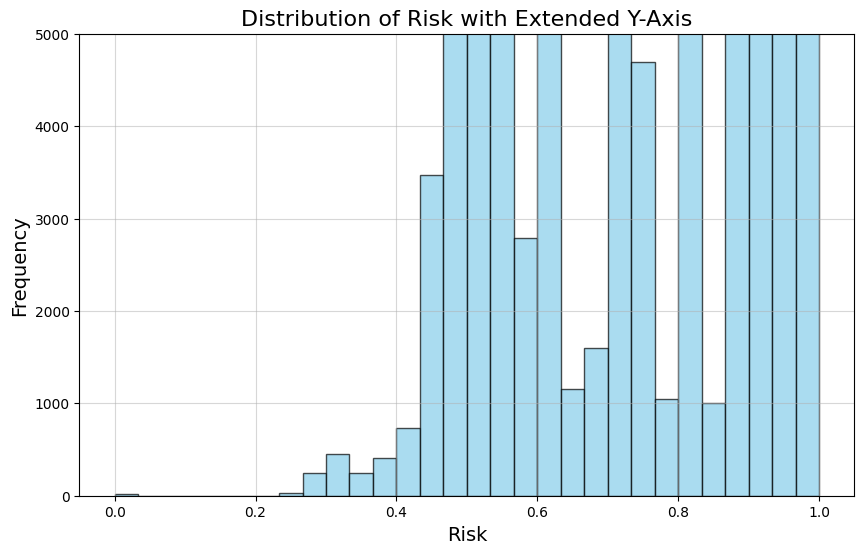

In [18]:
# Adjusting the y-axis to zoom in
plt.figure(figsize=(10, 6))

# Histogram of 'risk'
plt.hist(gdf_result['risk_probability'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)

# Add titles and labels
plt.title('Distribution of Risk with Extended Y-Axis', fontsize=16)
plt.xlabel('Risk', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.ylim(0, 5000)  # Adjust the y-axis to highlight risk = 1
plt.grid(True, alpha=0.5)

# Show the plot
plt.show()

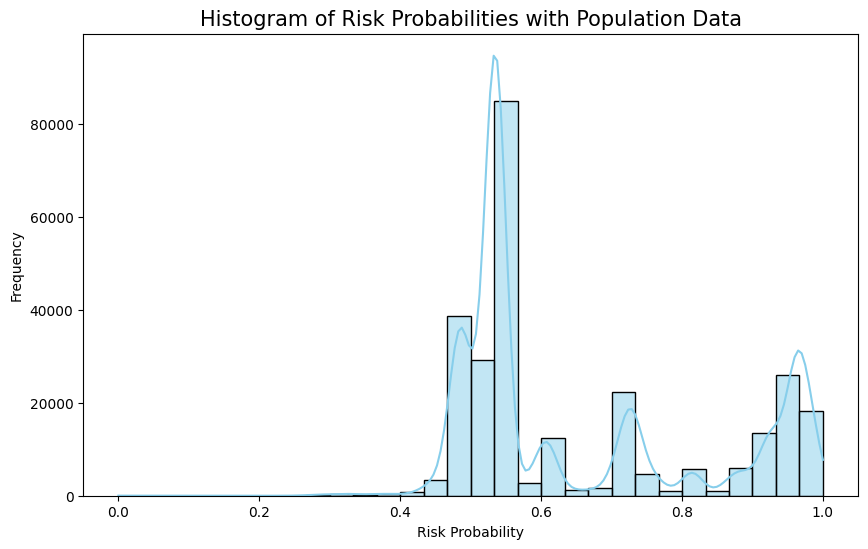

In [19]:
import seaborn as sns

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.histplot(gdf_result['risk_probability'], bins=30, kde=True, color='skyblue')

# Add labels and title
plt.title('Histogram of Risk Probabilities with Population Data', fontsize=15)
plt.xlabel('Risk Probability')
plt.ylabel('Frequency')

# Show the plot
plt.show()

/var/folders/p3/gs65vvgs1wd90mnxb3q3hvy80000gp/T/ipykernel_72920/1574042676.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('RdYlBu_r')


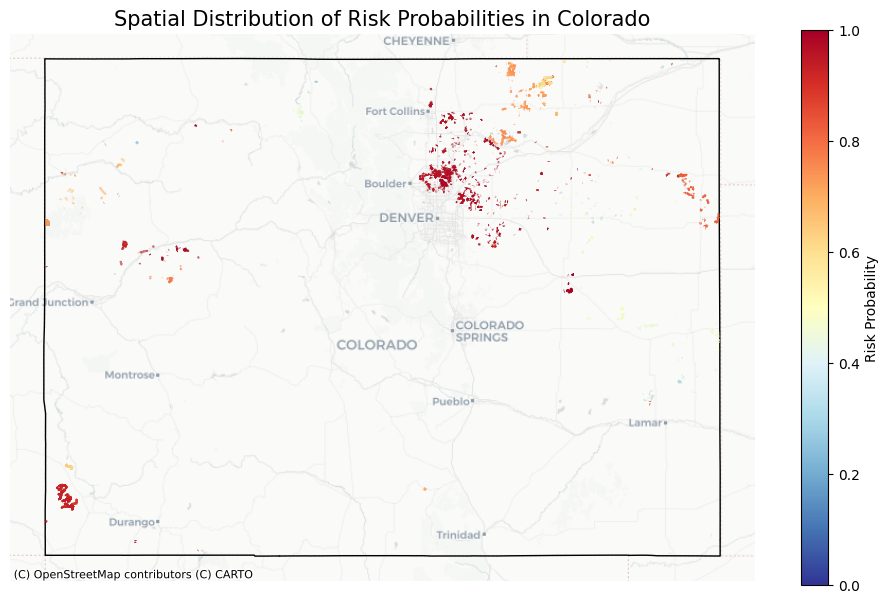

In [17]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx  # Import contextily for basemap

# Read Colorado state boundary
url = 'https://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_us_state_500k.zip'
states = gpd.read_file(url)
colorado = states[states['NAME'] == 'Colorado']

# Ensure CRS matches
if gdf_result.crs != colorado.crs:
    gdf_result = gdf_result.to_crs(colorado.crs)

# Clip data to Colorado
gdf_colorado = gpd.clip(gdf_result, colorado)

# Reproject to Web Mercator (EPSG:3857) for contextily
gdf_colorado = gdf_colorado.to_crs(epsg=3857)
colorado = colorado.to_crs(epsg=3857)

# Use reversed 'RdYlBu' colormap which goes from blue to red
cmap = plt.cm.get_cmap('RdYlBu_r')

# Plotting
fig, ax = plt.subplots(figsize=(12, 12))

# Plot Colorado boundary
colorado.boundary.plot(ax=ax, color='black', linewidth=1)

# Plot risk probabilities
gdf_colorado.plot(
    column='risk_probability',
    ax=ax,
    cmap=cmap,
    legend=True,
    legend_kwds={
        'label': "Risk Probability",
        'orientation': "vertical",
        'shrink': 0.6
    },
    alpha=0.7
)

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Set title and remove axes
ax.set_title('Spatial Distribution of Risk Probabilities in Colorado', fontsize=15)
ax.set_axis_off()

# Show the plot
plt.show()

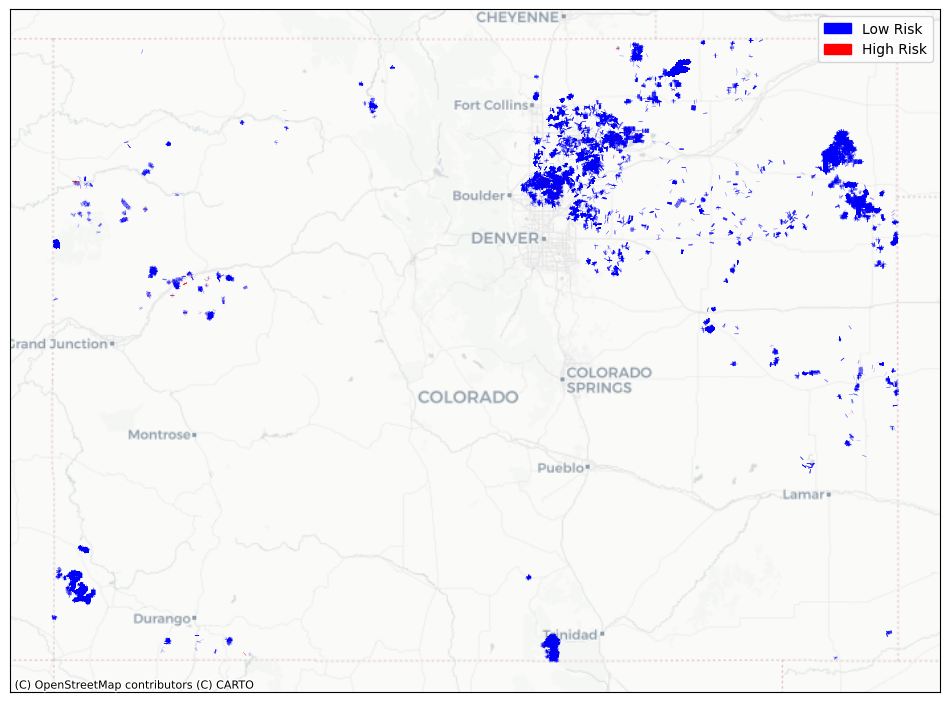

In [18]:
import contextily as ctx
from matplotlib.colors import ListedColormap, Normalize
import matplotlib.patches as mpatches

# Load Data
combined_gdf = gpd.read_file('combined_gdf.geojson')

# Convert CRS to EPSG:3857 for contextily base map
combined_gdf_wm = combined_gdf.to_crs(epsg=3857)

# Define custom colors and normalization
cmap = ListedColormap(['blue', 'red'])
norm = Normalize(vmin=0, vmax=1)

# Sort the data by risk level, assuming higher risk has higher numerical value
combined_gdf_wm = combined_gdf_wm.sort_values(by='risk')

# Plotting
fig, ax = plt.subplots(figsize=(12, 12))  # Increased plot size
combined_gdf_wm.plot(column='risk', ax=ax, cmap=cmap, norm=norm, alpha=0.7, linewidth=3)  # Increased line width for better visibility

# Add base map
# ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Create custom legend
low_risk_patch = mpatches.Patch(color='blue', label='Low Risk')
high_risk_patch = mpatches.Patch(color='red', label='High Risk')
plt.legend(handles=[low_risk_patch, high_risk_patch], loc='upper right')

# ax.set_title('Spatial Distribution of Flowline Risk in Colorado')
ax.set_xticks([])  # Remove x ticks for cleaner look
ax.set_yticks([])  # Remove y ticks

plt.show()

# Stats about Risk Probability

In [20]:
# Compute the mean feature vector of risk = 1 instances
X_risk1_mean = X_risk1.mean(axis=0)

In [23]:
from sklearn.preprocessing import normalize

# Convert to numpy arrays
X_array = X.values
X_risk1_mean_array = X_risk1_mean.values.reshape(1, -1)

# Normalize the feature vectors
X_normalized = normalize(X_array, axis=1)
X_risk1_mean_normalized = normalize(X_risk1_mean_array, axis=1)


In [24]:
import numpy as np

# Compute element-wise products (feature contributions)
feature_contributions = X_normalized * X_risk1_mean_normalized

# Sum over features to get similarity scores
similarity_scores = feature_contributions.sum(axis=1)

In [25]:
# Compute average contribution of each feature across all instances
average_feature_contributions = feature_contributions.mean(axis=0)

# Create a DataFrame with feature names and their average contributions
feature_contributions_df = pd.DataFrame({
    'Feature': X.columns,
    'AverageContribution': average_feature_contributions
})

# Sort features by average contribution
feature_contributions_df = feature_contributions_df.sort_values(by='AverageContribution', ascending=False)

/var/folders/p3/gs65vvgs1wd90mnxb3q3hvy80000gp/T/ipykernel_73063/911048466.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


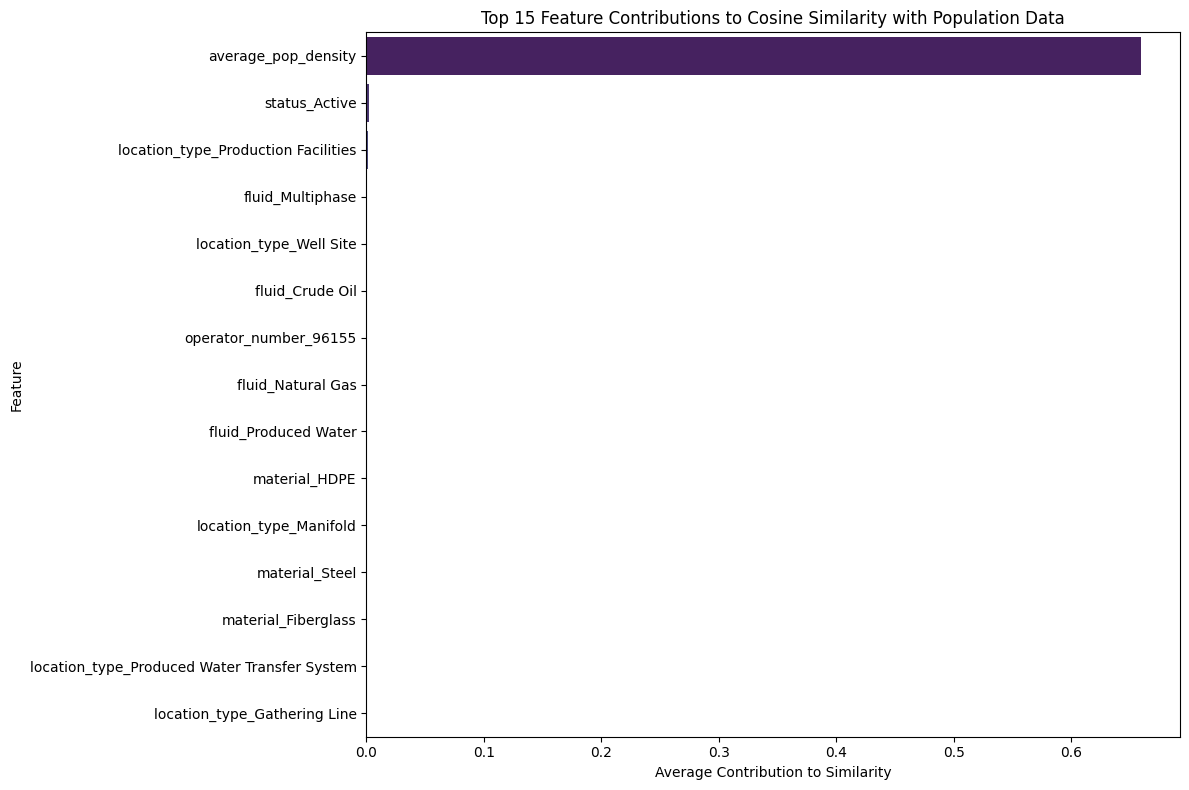

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the top 15 features contributing to similarity
plt.figure(figsize=(12, 8))
sns.barplot(
    x='AverageContribution',
    y='Feature',
    data=feature_contributions_df.head(15),
    palette='viridis'
)
plt.title('Top 15 Feature Contributions to Cosine Similarity with Population Data')
plt.xlabel('Average Contribution to Similarity')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()